<a href="https://colab.research.google.com/github/yexf308/AdvancedMachineLearning/blob/main/UMAP_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pylab inline 
from IPython.display import Image
import numpy.linalg as LA
from time import time
from sklearn.metrics import pairwise_distances

Populating the interactive namespace from numpy and matplotlib


# UMAP: Uniform Manifold Approximation and Projection
refer to [summary1](https://pair-code.github.io/understanding-umap/) and [summary2](https://github.com/NikolayOskolkov/HowUMAPWorks/blob/master/HowUMAPWorks.ipynb). Also the code in the summary is acturally wrong.

 The original paper and its package [doc](https://umap-learn.readthedocs.io/en/latest/basic_usage.html) is very hard to follow. It clearly has very deep relation with TDA. I try to explain it without using TDA knowledge. 


## A bit summary on Dimensionality reduction algorithms
Most dimensionality reduction algorithms fit into either one of two broad categories:

- Matrix factorization: 
   - **Principle Component Analysis (PCA)**
   - Autoencoder (AMAT 592 Fall 2022)
   - Latent Dirichlet Allocation (LDA)
   - **Non-nagative matrix factorization** 
   - **Low rank matrix factorization**
   - Word2Vec, GloVe

- Neighbour Graphs:
  - **Laplacian Eigenmaps (LE)**
  - Hessian Eigenmaps
  - **Diffusion Maps**
  - Local Tangent Space Alignment (LTSA)
  - **Isomap**
  - **Locally linear Embedding**
  - **t-SNE**
  - **UMAP**  



$\def\m#1{\mathbf{#1}}$
$\def\mb#1{\mathbb{#1}}$
$\def\c#1{\mathcal{#1}}$
## Revisit t-SNE

- In high dimensions
\begin{align}
&P_{j|i}(\m{X})=\frac{\exp(-\|\m{x}^{(i)} -\m{x}^{(j)}\|^2/2\sigma_i^2)}{\sum_{k\ne i}\exp(-\|\m{x}^{(i)} -\m{x}^{(k)}\|^2/2\sigma_i^2)} \\
&P_{ij}(\m{X})=  \frac{P_{i|j}(\m{X})+P_{j|i}(\m{X})}{2N}
\end{align}
   - All pairwise distances are needed to calculate Gaussian probability of observing distances.
   - Normalize the Gaussian probability to be a probability 
   - Use desired perplexity to adjust the size of the neighbours $\sigma_i$. Smaller $\sigma_i$ will focus more on local structure and larger $\sigma_i$ focus on global struture. 

- In low dimensions
\begin{align}
Q_{ij}(\m{Z})= \frac{(1+\|\m{z}^{(i)}-\m{z}^{(j)}\|^2)^{-1}}{\sum_{k\ne l} (1+\|\m{z}^{(k)}-\m{z}^{(l)}\|^2)^{-1}}
\end{align}
  - Calculate the t-distribution for distances between all pairs of points and normalize to be a probability. 

- Initialize the embedding in low dimension with a standard Gaussian distribution. 

- The loss function is Kullback-Leibler divergence 
\begin{align}
L(\m{Z})=\mb{KL}(P(\m{X})||Q(\m{Z}))=\sum_{i\ne j} P_{ij}(\m{X})\log\frac{P_{ij}(\m{X})}{Q_{ij}(\m{Z})}
\end{align}




## UMAP 
- In high dimensions, (**locally varying metrics**)
   \begin{align}
   &P_{j|i} = \exp\left(-\frac{d(\m{x}^{(i)},\m{x}^{(j)})-\rho_i}{\sigma_i}\right) \\
   &P_{ij} = P_{j|i} +P_{i|j} - P_{j|i}P_{i|j}
   \end{align}
   - Only calculate the distance to its $k$ nearest neighbours to construct the initial high-dim graph. In other words, the probability that $\m{x}^{(i)}$ connects to $k+1$ nearest point is 0. In practice $k\sim 15$.
      - low $k$: focus more on local structure 

      - high $k$: represent the big-picture structure while losing fine detail.  

   - $\rho_i$: the distance from each data $\m{x}^{(i)}$ to its **first nearest neighbor** by default. In other words, the probability that $\m{x}^{(i)}$ connects to its nearest point is 1. 
      - It imposes a locally self-adjustable exponential kernel for each data point. 

      - Rather than using a fixed radius, it uses various radius here such that all points much be connected to at least its nearest neighbor. 

   - To search for $\sigma_i$: use binary search method to solve 
   \begin{align}
   2^{\sum_{j}P_{j|i}(\sigma_i)} = k 
   \end{align} 

   - $P_{j|i}$ interprets the probability that $\m{x}^{(i)}$ connects to 2nd to $k$th neighbors. UMAP doesn't apply normalization to these probabilities. 

   - UMAP uses different symmetrization method. It interprets as the probability of at least one edge exists ($i\rightarrow j$ or $j\rightarrow i$), which is the same as the probability that $i$ and $j$ share an edge. 

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/umap3.png?raw=true" width="500" />

<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/umap1.png?raw=true" width="500" />



<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/umap4.png?raw=true" width="500" />


<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/umap5.png?raw=true" width="500" />

- In low dimensions,
  \begin{align}
   Q_{ij}&=(1+a\|\m{z}^{(i)}-\m{z}^{(j)}\|^{2b})^{-1}\\
   &\approx\begin{cases}
        1 & \text{if } \|\m{z}^{(i)}-\m{z}^{(j)}\|\le \text{min_dist}  \\
        \exp\left(-(\|\m{z}^{(i)}-\m{z}^{(j)}\|-\text{min_dist})\right) &  \text{Otherwise}
            \end{cases}
  \end{align}

  - It uses the family of functions $(1+a\m{z}^{2b})^{-1}$. When $a=1, b=1$, it becomes t-distribution. The default UMAP hyperparameters is $a = 1.93$ and $b=0.79$. 

  -  UMAP finds $a$ and $b$ from non-linear least-square fitting for given `min_dist`. This can be used to avoid point overlaping in the same cluster. By default, it is 0.1. 
     - low values of `min_dist` leads to more tightly packed embeddings. 
     - Large values of `min_dist` will make UMAP pack points together more loosely, focusing instead on the preservation of the broad topological structure.

  - UMAP doesn't apply normalization to these probabilities. So it will dramatically reduce time of computing. 

- UMAP assigns initial low-dimensional coordiantes using **Graph Laplacian**. This should make UMAP less changing from run to run since it is not a random initialization anymore. The **motivation** is  minimzation of KL-divergence in the initial stage with early exageration is equivalent to constructing the Graph Laplacian (HW). 

- The loss function is **binary cross-entropy (CE)**
\begin{align}
L(Z)= \mb{CE}(P(\m{X}), Q(\m{Z})) = \sum_{i\ne j}\left(P_{ij}(\m{X})\log\frac{P_{ij}(\m{X})}{Q_{ij}(\m{Z})}+(1-P_{ij}(\m{X}))\log\frac{1-P_{ij}(\m{X})}{1-Q_{ij}(\m{Z})}\right)
\end{align} 

- Summary: Overall, two parameters, `k` and `min_dist`, which are effectively used to control the balance between local and global structure in the embedding.
<img src="https://github.com/yexf308/AdvancedMachineLearning/blob/main/image/umap6.png?raw=true" width="500" />




- For the binary cross-entropy, it is equilvalent to consider 
\begin{align}
&\ell_{ij} = -P_{ij}\log(Q(d_{ij})) - (1-P_{ij})\log(1-Q(d_{ij}))\\
& L(\m{Z})=\sum_{i\ne j} \ell_{ij}
\end{align}
where $Q(d_{ij})=\frac{1}{1+a d_{ij}^b} $ and $d_{ij}$ is the squared distance of $\m{z}^{(i)}$ and $\m{z}^{(j)}$, $d_{ij}=\|\m{z}^{(i)} - \m{z}^{(j)}\|^2$. 

- We have the following 
\begin{align}
&1-Q(d_{ij})= \frac{a d_{ij}^b}{1+a d_{ij}^b}, \qquad \frac{\partial Q(d_{ij})}{\partial d_{ij}} = -\frac{abd_{ij}^{b-1}}{(1+a d_{ij}^b)^2}.
\end{align} 
- Then the derivative with respect to $d_{ij}$ is 
\begin{align}
& \frac{\partial \ell_{ij}}{\partial d_{ij}} = -\frac{P_{ij}}{Q(d_{ij})}\frac{\partial Q(d_{ij})}{\partial d_{ij}}  +\frac{1-P_{ij}}{1-Q(d_{ij})}\frac{\partial Q(d_{ij})}{\partial d_{ij}}  \\
&=P_{ij}\frac{abd_{ij}^{b}}{d_{ij}(1+ad_{ij}^b)}- (1-P_{ij})\frac{b}{d_{ij}(1+ad_{ij}^b)} \\
&= P_{ij}\frac{b}{d_{ij}}-\frac{b}{d_{ij}(1+ad_{ij}^b)}=\frac{b}{d_{ij}}(P_{ij}-Q_{ij}).
\end{align} 

- The derivative of $L(\m{Z})$ with respect to $\m{z}^{(i)}$
\begin{align}
\nabla_{\m{z}^{(i)}}L(\m{Z})=\sum_{j\ne i}\frac{2b}{d_{ij}}(P_{ij}-Q_{ij})(\m{z}^{(i)}-\m{z}^{(j)})
\end{align}

This won't work!!

Rewrite it!
\begin{align}
& \nabla_{\m{z}^{(i)}}L(\m{Z}) =\sum_{j\ne i}\boxed{P_{ij}\frac{2abd_{ij}^{b}}{d_{ij}(1+ad_{ij}^b)}(\m{z}^{(i)}-\m{z}^{(j)})}- \boxed{(1-P_{ij})\frac{2b}{d_{ij}(1+ad_{ij}^b)}(\m{z}^{(i)}-\m{z}^{(j)})}
\end{align}
The first term is treated as attraction and the second term is treated as repulsion. 

In SGD, 
\begin{align}
 \nabla_{\m{z}^{(i)}}L(\m{Z})  \approx \begin{cases} \frac{2abd_{ij}^{b-1}}{(1+ad_{ij}^b)}(\m{z}^{(i)}-\m{z}^{(j)}) & \text{with probabily } P_{ij}, i\sim j   \\
 -\frac{2b}{(\epsilon+ d_{ij})(1+ad_{ij}^b)}(\m{z}^{(i)}-\m{z}^{(j)}) & \text{Otherwise } \end{cases}
\end{align}

The algorithm is actually implemented as follows, 
### In each epoch

For each connected edge $(i,j)$, 
  - $r \sim \text{U}(0,1)$: sample a random number uniformly

  - If $r< P_{ij}$, then 
      - $\m{z}^{(i)}\leftarrow \m{z}^{(i)} - \eta \frac{2abd_{ij}^{b-1}}{(1+ad_{ij}^b)}(\m{z}^{(i)}-\m{z}^{(j)})$

      - $\m{z}^{(j)}\leftarrow \m{z}^{(j)} - \eta \frac{2abd_{ij}^{b-1}}{(1+ad_{ij}^b)}(\m{z}^{(j)}-\m{z}^{(i)})$

      - For $\ell = 1, \dots, m$,
        - Uniformly sample an integer $s$ from 1 to N. 
        - $\m{z}^{(i)}\leftarrow \m{z}^{(i)} + \eta \frac{2b}{(\epsilon+ d_{ij})(1+ad_{ij}^b)}(\m{z}^{(i)}-\m{z}^{(j)})  $

This finish one epoch. 


### Family of distributions

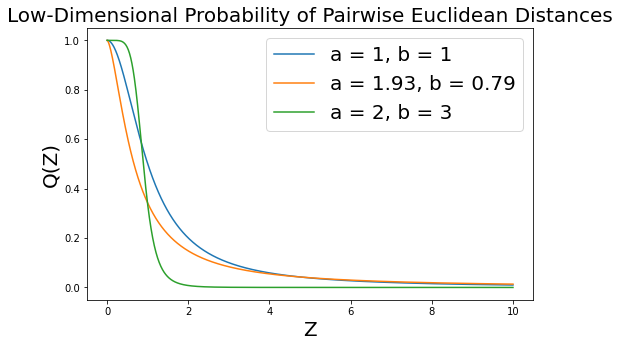

In [2]:
plt.figure(figsize=(8, 5))
z = np.linspace(0, 10, 1000)

my_prob = lambda z, a, b: np.power(1 + a*z**(2*b), -1)
plt.plot(z, my_prob(z, a = 1, b = 1))
plt.plot(z, my_prob(z, a = 1.93, b = 0.79))
plt.plot(z, my_prob(z, a = 2, b = 3))

plt.gca().legend(('a = 1, b = 1', 'a = 1.93, b = 0.79', 'a = 2, b = 3'), fontsize = 20)
plt.title("Low-Dimensional Probability of Pairwise Euclidean Distances", fontsize = 20)
plt.xlabel("Z", fontsize = 20); plt.ylabel("Q(Z)", fontsize = 20)
plt.show()

- We can see that the family of curves is very sensitive to the parameter $b$. At large $b$, $Q(Z)$ behaves almost like a **Heaviside step function**. This means in low dimension, datapoints that are below `min_dist` are equally tightly connected. 
It is exactly the reason that leads to the super-tightly packed clusters.  


[1.12271838 1.12152528]


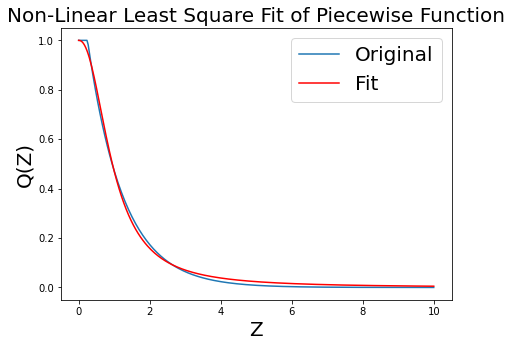

In [3]:
from scipy import optimize


MIN_DIST = 0.25

x = np.linspace(0, 10, 300)

def f(x, min_dist):
    y = []
    for i in range(len(x)):
        if(x[i] <= min_dist):
            y.append(1)
        else:
            y.append(np.exp(- x[i] + min_dist))
    return y

dist_low_dim = lambda x, a, b: 1 / (1 + a*x**(2*b))
    
p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))
print(p)

plt.figure(figsize=(7,5))
plt.plot(x, f(x, MIN_DIST))
plt.plot(x, dist_low_dim(x, p[0], p[1]), c = "red")
plt.title("Non-Linear Least Square Fit of Piecewise Function", fontsize = 20)
plt.gca().legend(('Original', 'Fit'), fontsize = 20)
plt.xlabel("Z", fontsize = 20)
plt.ylabel("Q(Z)", fontsize = 20)
plt.show()

In [52]:
a = 1.929
b= 0.7915

In [55]:
def cal_pairwise_dist_sq(X):
   return np.square(pairwise_distances(X, X, metric='euclidean'))

def find_rho(dist_matrix, n_neigh):
   """
   UMAP: Calculate distance from each data point to its first nearest neightbor
   """
   N = dist_matrix.shape[0]
   rho = np.zeros(N)
   dist_matrix_new = np.zeros([N,N])+ np.inf
   for i in range(N):
     dist_matrix_i = dist_matrix[i]
     sort_index    = np.argsort(dist_matrix_i)
     labels        = sort_index[1:n_neigh+1]
     rho[i]        = dist_matrix_i[sort_index[1]]
     dist_matrix_new[i,labels] = dist_matrix_i[labels]
   return rho, dist_matrix_new

def calc_p_matrix_row(dist_row,rho_row, sigma):
    """
    UMAP: For each row of Euclidean distance matrix (row) compute
    probability in high dimensions (1D array)
    """
    d = dist_row - rho_row
    #d[d < 0] = 0
    return exp(- d / sigma)  

def k(prob):
    """
    Compute n_neighbor = k (scalar) for each 1D array of high-dimensional probability
    """
    return np.power(2, sum(prob))

def sigma_binary_search(k_of_sigma, fixed_k):
    """
    Solve equation k_of_sigma(sigma) = fixed_k 
    with respect to sigma by the binary search algorithm
    """
    sigma_lower_limit = 0
    sigma_upper_limit = 1000
    for i in range(20):
        approx_sigma = (sigma_lower_limit + sigma_upper_limit) / 2
        if k_of_sigma(approx_sigma) < fixed_k:
            sigma_lower_limit = approx_sigma
        else:
            sigma_upper_limit = approx_sigma
        if np.abs(fixed_k - k_of_sigma(approx_sigma)) <= 1e-5:
            break
    return approx_sigma  

def symmetric_p(P):
   return P + P.T - P * P.T 


def P_UMAP(X, n_neigh):
    """
    UMAP: Given the data matrix X, compute
    matrix of joint probabilities with entries P_{ij}.
    """
    N = X.shape[0]
    prob = np.zeros((N,N))
    sigma_array = []

    # Get the distances from every point to every other. 
    # Get the first nearest neighbour
    X_dist_matrix= pairwise_distances(X, X, metric='euclidean')
    rho, X_dist_matrix = find_rho(X_dist_matrix,n_neigh)
    # Find optimal sigma for each row of this distances matrix
    # Calculate the probabilities based on these optimal sigmas
    for row in range(N):
      dist_row    = X_dist_matrix[row]
      rho_row     = rho[row]

      func = lambda sigma: k(calc_p_matrix_row(dist_row, rho_row, sigma))
      sigma_result = sigma_binary_search(func, n_neigh)
      prob[row]    = calc_p_matrix_row(dist_row, rho_row, sigma_result)
      sigma_array.append(sigma_result)
    
    # Calculate symmetrical P
    P = symmetric_p(prob)
    return P, sigma_array



In [54]:
def P_to_edge(P): 
  N = P.shape[0]
  N_entry = count_nonzero(P)
  non_zero_index = transpose(nonzero(P))
  
  edges_P = []
  
  for i in range(N_entry):
    index_0 = non_zero_index[i,0]
    index_1 = non_zero_index[i,1]
    if index_1 > index_0:
      edges_P.append([index_0, index_1, P[index_0, index_1]])
      
  return edges_P
  


In [95]:
def Q_umap(Z,a,b):
    """
    Compute matrix of probabilities q_ij in low-dimensional space
    """
    Z_dist_matrix_sq = cal_pairwise_dist_sq(Z)
    inv_distances = np.power(1 + a * Z_dist_matrix_sq**b, -1)
    np.fill_diagonal(inv_distances, 0.)
    return inv_distances

def off_diag_sum(M):
    return np.sum(M) - np.trace(M)    

    
def CE(P, Q):
    """
    Compute Cross-Entropy (CE) from matrix of high-dimensional probabilities 
    and coordinates of low-dimensional embeddings
    """
    P = np.clip(P, 1e-8, 1-1e-8)
    Q = np.clip(Q, 1e-8, 1-1e-8)
    return off_diag_sum(P * np.log(P) + (1-P)*np.log(1-P) - P * np.log(Q) - (1 - P) * np.log(1 - Q))


def CE_grad(P,Q,Z, Z_dist_matrix_sq, b):
    """Estimate the gradient of CE cost with respect to Z."""
    # \sum_j 2b(P_{ij}-Q_{ij})(z_i-z_j)/||z_i-z_j||^2
    # just to prevent the situation to divide zero

    pq_diff = P - Q  # NxN matrix
    pq_expanded = np.expand_dims(pq_diff, 2)
    Z_diffs = np.expand_dims(Z, 1) - np.expand_dims(Z, 0)

    #Expand our distances matrix 
    distances_expanded = np.expand_dims(Z_dist_matrix_sq, 2) +1e-3
    Z_diffs_wt = Z_diffs / distances_expanded
    grad = 2. * b * (pq_expanded * Z_diffs_wt).sum(1)
    return grad   


In [129]:
def one_epoch( edges_P, Z, eta, M=5):

  np.random.shuffle(edges_P)
  N_entry = len(edges_P)
  N       = Z.shape[0]
  for k in range(N_entry):
    r = np.random.uniform()
    if r < edges_P[k][2]:
      i = edges_P[k][0]
      j = edges_P[k][1]
      dist_sq_ij = sum((Z[i] - Z[j])**2)
      attraction =  2*a*b* dist_sq_ij**(b-1) * (Z[i] - Z[j]) /(1+a*dist_sq_ij**b)
      attraction = clip(attraction, -4, 4)
      Z[i] = Z[i] - eta * attraction 
      Z[j] = Z[j] + eta * attraction
      for l in range(M):
        s = np.random.randint(N)
        while P[i,s] >0:
          s = np.random.randint(N)
        
        dist_sq_is = sum((Z[i] - Z[s])**2)
        repulsion = 2*b* (Z[i] - Z[s])/((1e-3 + dist_sq_is) * (1+a*dist_sq_is**b)) 
        repulsion = clip(repulsion, -4, 4)
        Z[i] = Z[i] + eta * repulsion 
        Z[s] = Z[s] - eta * repulsion 

  return Z     


    


In [ ]:
edges_P

### 0. Load the data

In [57]:
from sklearn.datasets import load_digits
digits = load_digits() 

X = digits.data
y = digits.target 

X = X[(y==0) | (y==1) | (y==2) | (y==3)|(y==4)]
y = y[(y==0) | (y==1) | (y==2) | (y==3) | (y==4)]
n = X.shape[0]
print("\nThis data set contains " + str(n) + " samples")
print("\nDimensions of the  data set: ")
print(X.shape)


This data set contains 901 samples

Dimensions of the  data set: 
(901, 64)


### 1. Calculate pairwise distance
### 2. Calculate $\sigma_i$ and  Calculate $P$ matrix given `n_neigh`.

In [58]:
n_neigh = 15 # same as K in KNN
t0= time()
P, sigma_array = P_UMAP(X, n_neigh)
t1= time()
print("Calculating sigmas and P time: "+str(t1-t0))
print("\nMean sigma = " + str(mean(sigma_array)))


Calculating sigmas and P time: 2.641113758087158

Mean sigma = 3.255983833202908


In [59]:
edges_P = P_to_edge(P)


In [11]:
len(edges_P)

9197

### 3. Estimate hyperparameters a and b


In [97]:
MIN_DIST = 0.25
p , _ = optimize.curve_fit(dist_low_dim, x, f(x, MIN_DIST))
a = p[0]
b = p[1] 
print("Hyperparameters a = " + str(a) + " and b = " + str(b))


Hyperparameters a = 1.1227183788461688 and b = 1.1215252782501515


### 4. Laplacian Eigenmap as initial guess


### 5. Running Gradient Descent optimization.


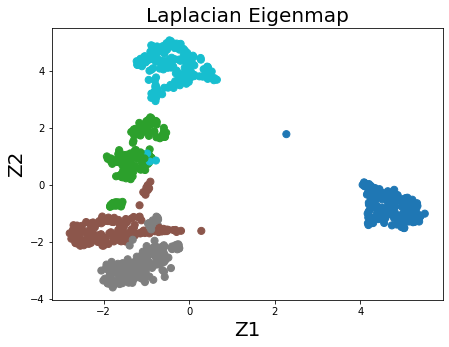

Running Gradient Descent: 

Cross-Entropy = 230200.54923261364 after 0 iterations
Cross-Entropy = 218085.53100715642 after 1 iterations
Cross-Entropy = 216311.10756490016 after 2 iterations
Cross-Entropy = 215406.3059462831 after 3 iterations
Cross-Entropy = 214834.63925877385 after 4 iterations
Cross-Entropy = 214523.27475385493 after 5 iterations
Cross-Entropy = 214297.19218744038 after 6 iterations
Cross-Entropy = 214140.86145610886 after 7 iterations
Cross-Entropy = 214024.47444139613 after 8 iterations
Cross-Entropy = 213951.93816316605 after 9 iterations
Cross-Entropy = 213870.00643785702 after 10 iterations
Cross-Entropy = 213798.99084866137 after 11 iterations
Cross-Entropy = 213748.48096191694 after 12 iterations
Cross-Entropy = 213690.7280854319 after 13 iterations
Cross-Entropy = 213651.89410928293 after 14 iterations
Cross-Entropy = 213618.72774377628 after 15 iterations
Cross-Entropy = 213581.08520332366 after 16 iterations
Cross-Entropy = 213557.10057103977 after 17 itera

In [145]:
# just to save some space here
from sklearn.manifold import SpectralEmbedding
model = SpectralEmbedding(n_components = 2, n_neighbors = 50)
#Z = model.fit_transform(X)*500
#Z = np.random.normal(loc = 0, scale = 1, size = (n, 2))*100
Z= Z_int
plt.figure(figsize=(7,5))
plt.scatter(Z[:, 0], Z[:, 1], c = y.astype(int), cmap = 'tab10', s = 50)
plt.title('Laplacian Eigenmap', fontsize = 20)
plt.xlabel("Z1", fontsize = 20)
plt.ylabel("Z2", fontsize = 20)
plt.show()


N_LOW_DIMS = 2

n_epoch = 50
n_span = arange(n_epoch)
eta_span = 0.1/((1+ n_span)**2) 
#LEARNING_RATE = 0.001

np.random.seed(12345)
CE_array = []
file_names =[]

print("Running Gradient Descent: \n")
for i in range(n_epoch):
  Q = Q_umap(Z,a,b)
  Z = one_epoch(edges_P, Z, eta_span[i] )


  
  #Z_grad  = CE_grad(P, Q, Z, dist, b)
  #Z_grad  = CE_grad1(P, Q, Z, dist, a,b)
  #Z = Z - LEARNING_RATE * Z_grad
  #print(norm(Z_grad,'fro'))
  #print(Z)


  #plt.figure(figsize=(10,7))
  #plt.scatter(Z[:,0], Z[:,1], c = y.astype(int), cmap = 'tab10', s = 50)
  #plt.title("UMAP on MNIST", fontsize = 20)
  #plt.xlabel("UMAP1", fontsize = 20); plt.ylabel("UMAP2", fontsize = 20)
  #file_name = 'UMAP_iter_' + str(i) + '.png'
  #plt.savefig(file_name)  
  #plt.close()
  #file_names.append(file_name)

  CE_current = CE(P,Q)
  CE_array.append(CE_current)
  if i % 1 == 0:
    print("Cross-Entropy = " + str(CE_current) + " after " + str(i) + " iterations")



In [55]:
repulsion = 2*b/((1e-3 + dist_sq) * (1+a*dist_sq**b))
attraction = 2*a*b*dist_sq**(b-1)/(1+a*dist_sq**b)

In [57]:
attraction[0,461]

1.7646992927696454

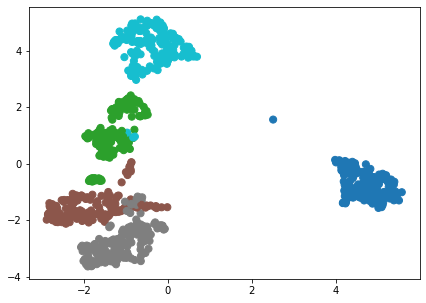

In [146]:
plt.figure(figsize=(7,5))
plt.scatter(Z[:, 0], Z[:, 1], c=y, cmap = 'tab10', s = 50)

In [144]:
Z_int = Z

In [ ]:
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

In [ ]:
from umap import UMAP


UMAP(min_dist=0.25, verbose=True)
Fri Apr 22 23:44:20 2022 Construct fuzzy simplicial set
Fri Apr 22 23:44:22 2022 Finding Nearest Neighbors
Fri Apr 22 23:44:22 2022 Finished Nearest Neighbor Search
Fri Apr 22 23:44:22 2022 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

Fri Apr 22 23:44:43 2022 Finished embedding


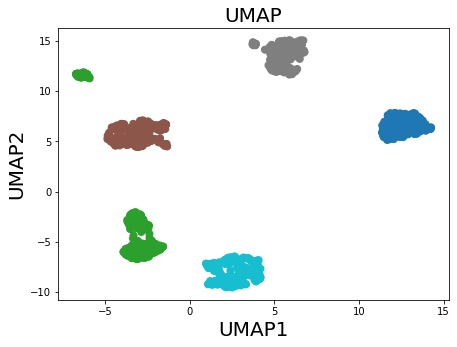

In [ ]:
plt.figure(figsize=(7,5))
model = UMAP(n_neighbors = 15, min_dist = 0.25, n_components = 2, verbose = True)
umap = model.fit_transform(X)
plt.scatter(umap[:, 0], umap[:, 1], c = y.astype(int), cmap = 'tab10', s = 50)
plt.title('UMAP', fontsize = 20)
plt.xlabel("UMAP1", fontsize = 20)
plt.ylabel("UMAP2", fontsize = 20)
plt.show()